# Data pipeline for unet
Define tensorflow datasets that contain the mask either as one channel image or as N channels = N classes one hot coded

## SELECT MASK TYPE HERE
* 1 = original
* 2 = astro masks replaced with clustering + Gauss filter
* 3 = astro masks replaced with clustering + SIFT

In [1]:
# Select mask type here
mask_type = int(input("Select mask type: [1] = original, [2] = clustered/Gauss, [3] = clustered/SIFT, 1, 2 or 3:"))

if mask_type==1:
    print("Original masks selected")
elif mask_type==2:
    print("Original masks for cort/shsy5y and clustered/Gauss masks for astro selected")
elif mask_type==3:
    print("Original masks for cort/shsy5y and clustered/SIFT masks for astro selected")

Select mask type: [1] = original, [2] = clustered/Gauss, [3] = clustered/SIFT, 1, 2 or 3: 2


Original masks for cort/shsy5y and clustered/Gauss masks for astro selected


In [2]:
# Select appropriate mask folder (separate imports since main imports below are written to a .py script)
import os
import pathlib
import shutil

# Get the directory of the repository
curr_dir = os.getcwd()
parent_dir = pathlib.Path(curr_dir).parents[1]

mask_path = f"{parent_dir}/data/data_preprocessed/"

if mask_type==1:
    mask_folder = mask_path +  "sliced_images/masks/"
    unsliced_mask_folder = mask_path + "mask_groundtruth/"
elif mask_type==2:
    mask_folder = mask_path +  "sliced_images/masks_cg/"
    unsliced_mask_folder = mask_path + "mask_cluster/masks_cg/"
elif mask_type==3:
    mask_folder = mask_path +  "sliced_images/masks_cs/"
    unsliced_mask_folder = mask_path + "mask_cluster/masks_cs/"

Copy the content of the selected mask folder into a new folder from which the masks are read after model training (to ensure that the correct masks are used for IoU computation)

In [3]:
# Sliced masks
dir_source = mask_folder
dir_target = mask_path + "sliced_images/masks_used_for_model/"

try: # First, delete the masks_used_for_model folders if they exist
    shutil.rmtree(dir_target)
except:
    print("No folder deleted")
    
shutil.copytree(dir_source, dir_target, dirs_exist_ok=True)

'/Users/philipp/neuefische/WHAT-THE-CELL...-AND-WHERE-/data/data_preprocessed/sliced_images/masks_used_for_model/'

In [4]:
# Unsliced masks
dir_source = unsliced_mask_folder
dir_target = mask_path + "masks_used_for_model/"

try: # First, delete the masks_used_for_model folders if they exist
    shutil.rmtree(dir_target)
except:
    print("No folder deleted")
    
shutil.copytree(dir_source, dir_target, dirs_exist_ok=True)

'/Users/philipp/neuefische/WHAT-THE-CELL...-AND-WHERE-/data/data_preprocessed/masks_used_for_model/'

In [5]:
# Fixed seed for reproducability
RSEED = 42

# Remove any file that gets constructed by the notebook.
!rm -f image_modeling.py
!rm -r  CSVs

To enable writing of code to a separate .py file:

In [6]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
        print("Appended to file ", file)
    else:
        print('Written to file:', file)
    with open(file, mode) as f:
        f.write(cell.format(**globals()))        
    get_ipython().run_cell(cell)

Import needed libraries. `%%write_and_run image_modeling.py` is the call of the register cell magic from above in 'w' mode (default). It writes the imports at the beginning of the `image_modeling.py`.

In [7]:
%%write_and_run image_modeling.py
import pathlib
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import imageio

Written to file: image_modeling.py


Print the tensorflow version and set the threshold for what messages will be logged. 

In [8]:
print(tf.__version__)
tf.compat.v1.logging.set_verbosity(v=tf.compat.v1.logging.INFO)

2.8.0


## Data preparation

Now we will use shell commands to look at the data, clean the paths to the images and split our data into train and evaluation set.

In [9]:
data_dir = f"{parent_dir}/data/data_preprocessed/sliced_images/images/"

# Read the .csv containing the paths to the augmented images
df = pd.read_csv("../run_once_preprocessing/cells_split_id.csv")

df["id_mergekey"] = df["id"].apply(lambda x: x.split("_")[0])

# Do train/test split on this df to ensure that all augmented images (e.g., the sliced crops)
# end up either in train, test, or eval instead of being distributed across sub-datasets (i.e., avoid data leakage)
df_for_split = df.copy()
df_for_split.drop_duplicates(subset = "id_mergekey", inplace = True)


df["id_mask"] = mask_folder + df["id"] + "_mask.png"
df["id_mask_oh"] = mask_folder + df["id"] + "_mask_oh.png"

df['id'] = data_dir + df["id"] + '.png'

df_for_split.head()

,id,cell_type,id_mergekey
0,d3d272e75cdb_a,astro,d3d272e75cdb
1,f653c5eec0f8_d,shsy5y,f653c5eec0f8
2,680c18cb5fea_b,cort,680c18cb5fea
3,77f5123c8582_b,shsy5y,77f5123c8582
4,49d4a04f398c_c,cort,49d4a04f398c


## Train/eval/test split
* train = training data
* eval = validation data used during model training
* test = test data for predictions after model training

The code below first splits the test data (which should remain untouched) from the full data set. The random seed should remain fixed to ensure that we always get the same images as test data.

In [10]:
# 1. We reserve 20% = ~121 (x4 due to the slicing) images of our data as test data
train, test, y_train, y_test = train_test_split(df_for_split, 
                                                df_for_split.cell_type, 
                                                test_size=0.2, random_state=RSEED)

# Inner merge of test and df to get the paths to masks and images (in df) only for the images contained in test after the split.
test = test[["id_mergekey"]].merge(df, on = "id_mergekey", how = "inner")
test.sort_values(by = "id", inplace = True)

# To test if we have data leakage (sum should be zero)
# sum(test["id_mergekey"].apply(lambda x: x in train["id_mergekey"]).astype(int))

# Store test data in a new folder
!mkdir -p CSVs

test[["id","id_mask"]].to_csv('CSVs/cells_test.csv', header = False, index = False) # labels = single channel masks
test[["id","id_mask_oh"]].to_csv('CSVs/cells_test_oh.csv', header = False, index = False) # labels = one-hot encoded masks

In [11]:
# Split the test csv by cell type
cell_types = df_for_split.cell_type.unique().tolist()
for which_cell in cell_types:
    test[test.cell_type == which_cell][["id","id_mask"]].to_csv('CSVs/cells_test_{}.csv'.format(which_cell), header = False, index = False)
    test[test.cell_type == which_cell][["id","id_mask_oh"]].to_csv('CSVs/cells_test_oh_{}.csv'.format(which_cell), header = False, index = False)

Here, we separate the eval data from the training data

In [12]:
# 2. We keep 10% = ~48 images of the remaining train data as eval data.
# The training set now contains ~436 images.
train, test, y_train, y_test = train_test_split(train, 
                                                train.cell_type, 
                                                test_size=0.1, random_state=RSEED)

train = train[["id_mergekey"]].merge(df, on = "id_mergekey", how = "inner")
train.sort_values(by = "id", inplace = True)

test  = test[["id_mergekey"]].merge(df, on = "id_mergekey", how = "inner")
test.sort_values(by = "id", inplace = True)

# Store train as train data and test as eval data
train[["id","id_mask"]].to_csv('CSVs/cells_train.csv', header = False, index = False) # labels = single channel masks
train[["id","id_mask_oh"]].to_csv('CSVs/cells_train_oh.csv', header = False, index = False) # labels = one-hot encoded masks

test[["id","id_mask"]].to_csv('CSVs/cells_eval.csv', header = False, index = False) # labels = single channel masks
test[["id","id_mask_oh"]].to_csv('CSVs/cells_eval_oh.csv', header = False, index = False) # labels = one-hot encoded masks



In [13]:
# Split train and eval by cell type
for which_cell in cell_types:
    train[train.cell_type == which_cell][["id","id_mask"]].to_csv('CSVs/cells_train_{}.csv'.format(which_cell), header = False, index = False)
    train[train.cell_type == which_cell][["id","id_mask_oh"]].to_csv('CSVs/cells_train_oh_{}.csv'.format(which_cell), header = False, index = False)
    
    test[test.cell_type == which_cell][["id","id_mask"]].to_csv('CSVs/cells_eval_{}.csv'.format(which_cell), header = False, index = False)
    test[test.cell_type == which_cell][["id","id_mask_oh"]].to_csv('CSVs/cells_eval_oh_{}.csv'.format(which_cell), header = False, index = False)

## Define functions to process the data

From now on we will use python and Tensorflow to define some variables and functions to be used in the second notebook when we train our CNN to segment images of cells.

We set some parameters for the model and call the register cell magic `write_and_run` again this time with the `-a` flag. This makes sure that the content of the cell is appended to `image_modeling.py` and existing lines are not overwritten.

In [14]:
%%write_and_run -a image_modeling.py

# We set some parameters for the model
CHANNELS = 3 #image RGB channels

BATCH_SIZE = 32
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

VALIDATION_SIZE = pd.read_csv("CSVs/cells_eval.csv").shape[0]
VALIDATION_STEPS = VALIDATION_SIZE // BATCH_SIZE



Appended to file  image_modeling.py


In [15]:
%%write_and_run -a image_modeling.py

# Define the function that decodes in the images
def decode_image_seg(image, mask, reshape_dim):
    # PNG is a compressed image format. So we want to 
    # convert this format to a numpy array we can compute with.
    image = tf.image.decode_png(image, channels=CHANNELS)
    mask = tf.image.decode_png(mask, channels=CHANNELS_MASK)
    # 'decode_jpeg' returns a tensor of type uint8. We need for 
    # the model 32bit floats. Actually we want them to be in 
    # the [0,1] interval.
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Now we can resize to the desired size.
    image = tf.image.resize(image, reshape_dim)
    mask = tf.image.resize(mask, reshape_dim)
    
    return image, mask



Appended to file  image_modeling.py


In [16]:
%%write_and_run -a image_modeling.py

# The train set actually gives only the paths to the training images.
# We want to create a dataset of training images, so we need a 
# function that can handle this for us.
def decode_dataset_seg(data_row):
    record_defaults = ['path', 'path_mask']
    filename, filename_mask = tf.io.decode_csv(data_row, record_defaults)
    image_bytes = tf.io.read_file(filename=filename)
    mask_bytes = tf.io.read_file(filename=filename_mask)
    return image_bytes, mask_bytes



Appended to file  image_modeling.py


In [17]:
%%write_and_run -a image_modeling.py

# Next we construct a function for pre-processing the images.
def read_and_preprocess_seg(image_bytes, mask_bytes, augment_randomly=False):
    if augment_randomly:
        image, mask = decode_image_seg(image_bytes, mask_bytes, [HEIGHT, WIDTH])
        
        # # Randomly select whether to apply an augmentation independently for each augmentation type
        if random.randint(0,1)==1:
            image = tf.image.rot90(image)
            mask = tf.image.rot90(mask)
        if random.randint(0,1)==1:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
        if random.randint(0,1)==1:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)
        
        # Randomly select and apply only one of three augmentations
        # augment_generator = random.randint(0,3)
        # if augment_generator == 1:
        #     image = tf.image.rot90(image)
        #     mask = tf.image.rot90(mask)
        # elif augment_generator == 2:
        #     image = tf.image.flip_left_right(image)
        #     mask = tf.image.flip_left_right(mask)
        # elif augment_generator == 3:
        #     image = tf.image.flip_up_down(image)
        #     mask = tf.image.flip_up_down(mask)
           
    else:
        image, mask = decode_image_seg(image_bytes, mask_bytes, [HEIGHT, WIDTH])
        
    return image, mask

def read_and_preprocess_with_augmentation_seg(image_bytes, mask_bytes): 
    return read_and_preprocess_seg(image_bytes, mask_bytes, augment_randomly=True)



Appended to file  image_modeling.py


In [18]:
%%write_and_run -a image_modeling.py

# Now we can create the dataset.
def load_dataset_seg(file_of_filenames, batch_size, training=True):
    # We create a TensorFlow Dataset from the list of files.
    # This dataset does not load the data into memory, but instead
    # pulls batches one after another.
    dataset = tf.data.TextLineDataset(filenames=file_of_filenames).\
        map(decode_dataset_seg)
    
    if training:
        dataset = dataset.map(read_and_preprocess_with_augmentation_seg).\
            shuffle(SHUFFLE_BUFFER).\
            repeat(count=None) # Infinite iterations
    else: 
        # Evaluation or testing
        dataset = dataset.map(read_and_preprocess_seg).\
            repeat(count=1) # One iteration
            
    # The dataset will produce batches of BATCH_SIZE and will
    # automatically prepare an optimized number of batches while the prior one is
    # trained on.
    return dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)



Appended to file  image_modeling.py


## Testing the functions

Show examples for one-hot encoded masks

Metal device set to: Apple M1


2022-02-23 19:57:02.623399: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-23 19:57:02.623498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-23 19:57:02.950265: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


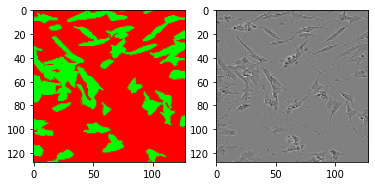

In [19]:
CHANNELS_MASK = 3
HEIGHT = 128 #image height
WIDTH = 128 #image width
train_path = 'CSVs/cells_train_oh.csv'

train_data = load_dataset_seg(train_path, 1, training=True)
# Create an iterator that runs over the training dataset.
it = iter(train_data)

# Iterate and see the pictures and labels
img_batch, mask = next(it)
mask = mask[0]
image = img_batch[0]

fig, ax = plt.subplots(1,2)
ax[0].imshow(mask)
ax[1].imshow(image)

Show examples for single-channel-encoded masks

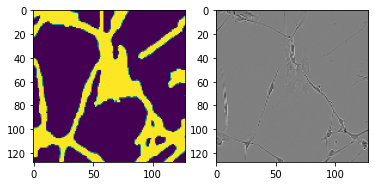

In [20]:
CHANNELS_MASK = 1
train_path = 'CSVs/cells_train.csv'

train_data = load_dataset_seg(train_path, 1, training=True)
# Create an iterator that runs over the training dataset.
it = iter(train_data)

# Iterate and see the pictures and labels
img_batch, mask = next(it)
mask = mask[0]
image = img_batch[0]

fig, ax = plt.subplots(1,2)
ax[0].imshow(mask)
ax[1].imshow(image)